> Projeto Desenvolve <br>
Programação Intermediária com Python <br>
Profa. Camila Laranjeira (mila@projetodesenvolve.com.br) <br>

# 3.11 - Data Model

## Exercícios

#### Q1. `dataclass`
Exercício adaptado de [codechalleng.es/bites/154/](https://codechalleng.es/bites/154/) e [codechalleng.es/bites/320/](https://codechalleng.es/bites/320/).

Neste desafio, você deve escrever uma `dataclass` chamada `Bite` que gerencia 3 atributos: `number`, `title` e `level`. Seus tipos são:
* `number` - `int`, 
* `title` - `str`, 
* `level` -  classe `Enum` chamada `BiteLevel` com os atributos `Beginner`, `Intermediate`, `Advanced`. 

Exemplo de dado: `{'number': 154, 'title': 'Escreva uma dataclass', 'level': BiteLevel.Intermediate}`

As características dessa classe são:
* O atributo`level` tem um valor padrão `BiteLevel.Beginner`
* Uma coleção de objetos `Bite` tem que ser ordenável somente pelo atributo `number`
* Implemente o método especial `__str__` para imprimir o Bite na forma `f'{number} - {title} ({level})'`

Teste sua classe executando o seguinte código:
```python
bites = []
bites.append(Bite(154, 'Escreva uma dataclass', 'Intermediate'))
bites.append(Bite(1, 'Some n valores'))
bites.append(Bite(37, 'Reescreva um loop com recursão', 'Intermediate'))

for b in bites.sort(): print(b)
# Ordem esperada na saída:
# 1 - Some n valores (Beginner)
# 37 - Reescreva um loop com recursão (Intermediate)
# 154 - Escreva uma dataclass (Intermediate)
```

In [1]:
from dataclasses import dataclass, field
from enum import Enum


class BiteLevel(Enum):
    Beginner = "Beginner"
    Intermediate = "Intermediate"
    Advanced = "Advanced"


@dataclass(order=True)
class Bite:
    # Campo usado para ordenação
    number: int = field(compare=True)

    # Demais atributos (não usados na ordenação)
    title: str = field(compare=False)
    level: BiteLevel = field(default=BiteLevel.Beginner, compare=False)

    def __post_init__(self):
        # Permite passar 'Intermediate' como string
        if isinstance(self.level, str):
            self.level = BiteLevel[self.level]

    def __str__(self):
        return f"{self.number} - {self.title} ({self.level.value})"


# ---------- Teste solicitado ----------
bites = []
bites.append(Bite(154, 'Escreva uma dataclass', 'Intermediate'))
bites.append(Bite(1, 'Some n valores'))
bites.append(Bite(37, 'Reescreva um loop com recursão', 'Intermediate'))

# sort() retorna None, então usamos sorted()
for b in sorted(bites):
    print(b)


1 - Some n valores (Beginner)
37 - Reescreva um loop com recursão (Intermediate)
154 - Escreva uma dataclass (Intermediate)


#### Q2. `Pydantic`
> Adaptada desse [tutorial de Pydantic](https://github.com/adonath/scipy-2023-pydantic-tutorial/tree/main) criado por [Axel Donath](https://github.com/adonath) e [Nick Langellier](https://github.com/nlangellier).

Observe a seguinte lista de observações da previsão do tempo em Murmansk, Russia.
```python
data_samples = [
    {
        "date": "2023-05-20",
        "temperature": 62.2,
        "isCelsius": False,
        "airQualityIndex": "24",
        "sunriseTime": "01:26",
        "sunsetTime": "00:00",
    },
    {
        "date": "2023-05-21",
        "temperature": "64.4",
        "isCelsius": "not true",
        "airQualityIndex": 23,
        "sunriseTime": "01:10",
        "sunsetTime": "00:16",
    },
    {
        "date": "2023-05-22",
        "temperature": 14.4,
        "airQualityIndex": 21,
    },
]
```

Escreva um script que calcule e imprima a temperatura média (em Celsius) em Murmansk para as datas fornecidas. Em seu script, você deve incluir um modelo Pydantic que registre com sucesso todos os elementos dados. Note que:

* Algumas amostras estão faltando dados. Você deve decidir quando o atributo pode ter um valor padrão ou quando definí-lo como opcional (`typing.Optional`). 
* Você precisará implementar pelo menos um validador de campo para transformar atributos. Dica: teste primeiro quais vão falhar :)



In [3]:
from typing import Optional
from pydantic import BaseModel, field_validator
from datetime import date, time


class Weather(BaseModel):
    date: date
    temperature: float
    isCelsius: Optional[bool] = True
    airQualityIndex: int
    sunriseTime: Optional[time] = None
    sunsetTime: Optional[time] = None

    # temperature pode vir como string
    @field_validator("temperature", mode="before")
    def convert_temperature(cls, v):
        return float(v)

    # converter strings estranhas em booleanos
    @field_validator("isCelsius", mode="before")
    def convert_boolean(cls, v):
        if isinstance(v, bool) or v is None:
            return v

        s = str(v).strip().lower()
        if s in {"true", "1", "yes"}:
            return True
        if s in {"false", "0", "no", "not true"}:
            return False

        return True  # fallback seguro

    # converter AQI para int
    @field_validator("airQualityIndex", mode="before")
    def convert_aqi(cls, v):
        return int(v)

    # converter horários
    @field_validator("sunriseTime", "sunsetTime", mode="before")
    def convert_time_str(cls, v):
        if v is None:
            return None
        return time.fromisoformat(v)

    # converter Fahrenheit → Celsius usando ValidationInfo
    @field_validator("temperature", mode="after")
    def convert_to_celsius(cls, v, info):
        is_celsius = info.data.get("isCelsius", True)
        if not is_celsius:
            return (v - 32) * 5 / 9
        return v


# -------------------------
#        DADOS
# -------------------------

data_samples = [
    {
        "date": "2023-05-20",
        "temperature": 62.2,
        "isCelsius": False,
        "airQualityIndex": "24",
        "sunriseTime": "01:26",
        "sunsetTime": "00:00",
    },
    {
        "date": "2023-05-21",
        "temperature": "64.4",
        "isCelsius": "not true",
        "airQualityIndex": 23,
        "sunriseTime": "01:10",
        "sunsetTime": "00:16",
    },
    {
        "date": "2023-05-22",
        "temperature": 14.4,
        "airQualityIndex": 21,
    },
]


# -------------------------
#   CÁLCULO DA MÉDIA
# -------------------------

weather_items = [Weather(**entry) for entry in data_samples]

temps = [w.temperature for w in weather_items]
avg_temp = sum(temps) / len(temps)

print(f"Temperatura média em Celsius: {avg_temp:.2f}°C")

     

   





Temperatura média em Celsius: 47.00°C


#### Q3
> Adaptada desse [tutorial de Pydantic](https://github.com/adonath/scipy-2023-pydantic-tutorial/tree/main) criado por [Axel Donath](https://github.com/adonath) e [Nick Langellier](https://github.com/nlangellier).

Na célula a seguir, coletamos dados reais de uma das principais APIs de previsão do tempo, [open-meteo](https://open-meteo.com/en/docs). Não se preocupe em entender esse código, o mais importante é entender o resultado que ele retorna, ilustrado a seguir para uma coleta da temperatura dos últimos 15 dias em Itabira -MG. Caso deseje alterar a cidade de coleta, basta alimentar a latitude e longitude desejada, como nas opções a seguir.
* Itabira: `'latitude': -19.656655787605846, 'longitude': -43.228922960534476`
* Bom Despacho: `'latitude': -19.726308457732443, 'longitude': -45.27462803349767`

```python
{
  "latitude": -19.5,
  "longitude": -43.375,
  "generationtime_ms": 0.01800060272216797,
  "utc_offset_seconds": 0,
  "timezone": "GMT",
  "timezone_abbreviation": "GMT",
  "elevation": 2.0,
  "hourly_units": {
    "time": "iso8601",
    "temperature_2m": "\u00b0C"
  },
  "hourly": {
    "time": [
      "2024-07-19T00:00",
      "2024-07-19T01:00",
      "2024-07-19T02:00",
      ...
    ],
    "temperature_2m": [
      21.9,
      20.9,
      20.0,
      ... 
    ]
  }
}
```

Você deve escrever um modelo Pydantic `OpenMeteo` que receba diretamente a resposta dessa API, através do comando:
```python
dados = OpenMeteo(**response)
``` 

Para comportar a estrutura hierárquica desse dicionário (é um dicionário com alguns dicionários internos), você deve criar uma classe Pydantic para cada dicionário interno (`HourlyUnits` e `Hourly`), com seus respectivos atributos. Essas classes serão atributos da classe principal `OpenMeteo`, que terá também os outros atributos da resposta (`latitude`, `longitude`, etc.).



In [9]:
from pydantic import BaseModel, field_validator
from typing import List
from datetime import datetime


# -----------------------------
#   MODELOS INTERNOS
# -----------------------------

class HourlyUnits(BaseModel):
    time: str
    temperature_2m: str


class Hourly(BaseModel):
    time: List[datetime]
    temperature_2m: List[float]

    @field_validator("time", mode="before")
    def parse_times(cls, v):
        # converte lista de strings ISO → datetime
        return [datetime.fromisoformat(t) for t in v]


# -----------------------------
#   MODELO PRINCIPAL
# -----------------------------

class OpenMeteo(BaseModel):
    latitude: float
    longitude: float
    generationtime_ms: float
    utc_offset_seconds: int
    timezone: str
    timezone_abbreviation: str
    elevation: float

    hourly_units: HourlyUnits
    hourly: Hourly


In [ ]:

print(dados.hourly.temperature_2m[:5])
print(dados.hourly.time[0])


#### Q4. 

Com os dados carregados na questão anterior plote um gráfico de linha, com a biblioteca de sua preferência, onde o eixo `x` são os timestamps (data e hora) e o eixo `y` é a temperatura medida.

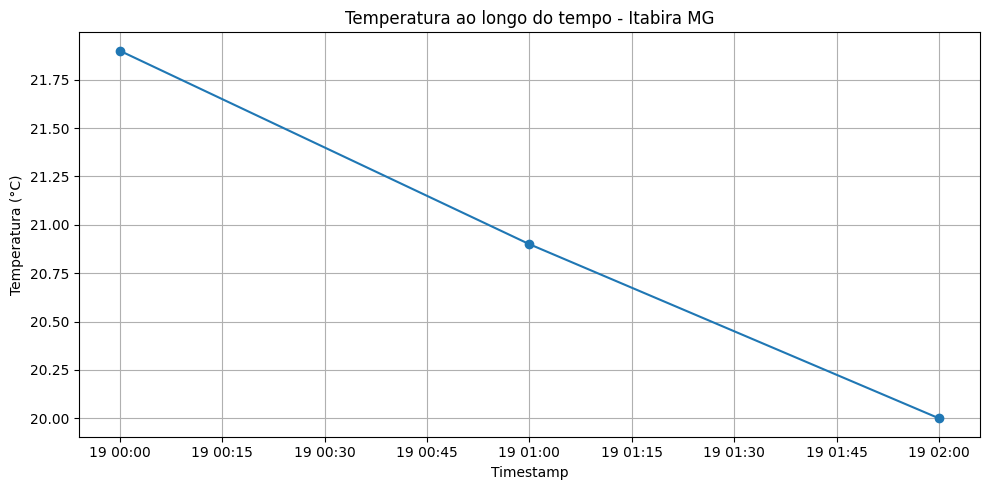

In [14]:
from pydantic import BaseModel, field_validator
from typing import List
from datetime import datetime
import matplotlib.pyplot as plt

# -----------------------------
#   MODELOS INTERNOS
# -----------------------------
class HourlyUnits(BaseModel):
    time: str
    temperature_2m: str

class Hourly(BaseModel):
    time: List[str]
    temperature_2m: List[float]

    @field_validator("time", mode="before")
    def parse_times(cls, v):
        return v  # mantemos string por enquanto; converteremos no gráfico

class OpenMeteo(BaseModel):
    latitude: float
    longitude: float
    generationtime_ms: float
    utc_offset_seconds: int
    timezone: str
    timezone_abbreviation: str
    elevation: float
    hourly_units: HourlyUnits
    hourly: Hourly

# -----------------------------
#    DADOS (exemplo com 3 timestamps)
# -----------------------------
response = {
  "latitude": -19.5,
  "longitude": -43.375,
  "generationtime_ms": 0.01800060272216797,
  "utc_offset_seconds": 0,
  "timezone": "GMT",
  "timezone_abbreviation": "GMT",
  "elevation": 2.0,
  "hourly_units": {
    "time": "iso8601",
    "temperature_2m": "°C"
  },
  "hourly": {
    "time": [
      "2024-07-19T00:00",
      "2024-07-19T01:00",
      "2024-07-19T02:00"
    ],
    "temperature_2m": [
      21.9,
      20.9,
      20.0
    ]
  }
}

# -----------------------------
#    CARREGAR OS DADOS
# -----------------------------
dados = OpenMeteo(**response)

# -----------------------------
#    PLOTAR GRÁFICO
# -----------------------------
tempos = [datetime.fromisoformat(t) for t in dados.hourly.time]
temperaturas = dados.hourly.temperature_2m

plt.figure(figsize=(10,5))
plt.plot(tempos, temperaturas, marker='o', linestyle='-')
plt.title("Temperatura ao longo do tempo - Itabira MG")
plt.xlabel("Timestamp")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()
